# US Gap Analysis Project - WV Breeding Bird Atlas Data Comparison

*Nathan Tarr and Jessie Jordan*

## Cover type associations in West Virginia Summarized Across All Species

We investigated the agreement between WV Breeding Bird Atlas (2011-2015) and USGS Gap Analysis Project data

In [1]:
import pandas as pd
import numpy as np
import repo_functions as fun
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 15)

In [2]:
# Call species lists and generate empty dataframes-----------------------------
specieslist = (pd.read_csv(fun.dataDir + "/SpeciesLists/WV_GAP_Atlas.csv", 
                           index_col ='strCommonName', header=0))
mastdf = pd.DataFrame(index=[ "Unusable", "Supported validation", 
                                        "Supported addition", 
                                        "Total detections"], 
                             columns=["Species", "detections"])
masteval = pd.DataFrame(index=[ "Unvalidated", "Validated", 
                              "Additions"], columns=["Species", 
                                            "GAP_types"])
allunmatch = []

# Load land cover crosswalk - slow loading for some reason
cross = pd.read_csv(fun.dataDir + "LandCover/land_cover_crosswalk.csv", 
                    header=0, dtype={'GAP_code': str}) 


In [3]:
for species in specieslist.index[0:]:
    try:
        # Perform crosswalk of detections from WV -> USGAP
        master, GAP_linked, unmatched, gap_types, wv_types = fun.cross_to_GAP(species, 
                                                    cross, print_tables=False)

        #Insert Species name into first column
        
        print(str("Species summary complete for ") + species)
        master_valid = master[master['evaluation'] == 'valid']
        master_add = master[master['evaluation'] == 'add_association']
        usable_df = pd.DataFrame(index=[ "Unusable", "Supported validation", 
                                        "Supported addition", 
                                        "Total detections"], 
                             columns=["detections"])
        usable_df.loc['Supported validation', 
                      'detections'] = int(master_valid[['detections']].sum())
        usable_df.loc['Supported addition', 
                      'detections'] = int(master_add[['detections']].sum())
        usable_df.loc['Total detections', 
                      'detections'] = wv_types['detections'].sum()
        usable_df.loc['Unusable', 
                      'detections'] = int(wv_types['detections'].sum() - 
                                          master_valid[['detections']].sum() - 
                                          master_add[['detections']].sum())
        usable_df.insert(0, "Species", species, True)
        usable_df = usable_df.fillna(0)
        mastdf = pd.concat([usable_df, mastdf])
        
        # Aggregate results for proportion of GAP systems validated------------
        eval_df = pd.DataFrame(index=[ "Unvalidated", "Validated", 
                                      "Additions"], columns=["GAP_types"])
        eval_df.loc['Unvalidated', "GAP_types"] = len(gap_types) - len(master_valid)
        eval_df.loc['Validated', "GAP_types"] = len(master_valid)
        eval_df.loc['Additions', "GAP_types"] = len(master_add)
        eval_df.insert(0, "Species", species, True)
        eval_df = eval_df.fillna(0)
        masteval = pd.concat([eval_df, masteval])
        print(eval_df)
        print(species + " add successful")
        #Generate a full list of unmatched habitat types across all species
        #(DOES NOT WORK, STILL GENERATING EMPTY DATFRAME)
        print(unmatched)
        allunmatch.append(unmatched)
        #def mergeDict(allunmatch, unmatched):
        #Merge dictionaries and keep values of common keys in list
            #allunmatch = {**allunmatch, **unmatched}
        #for key, value in allunmatch.items():
         #   if key in allunmatch and key in unmatched:
          #      allunmatch[key] = [value , allunmatch[key]]
        #return allunmatch
        # Merge dictionaries and add values of common keys in a list
        #allunmatch = mergeDict(allunmatch, unmatched)
    except Exception as e: 
            print(str(" concatonate failed for ") + species)  


0 of 0 GAP ecological system associations were validated.
Species summary complete for American Kestrel
                      Species  GAP_types
Unvalidated  American Kestrel          0
Validated    American Kestrel          0
Additions    American Kestrel          2
American Kestrel add successful
{'17': 20.0}
 concatonate failed for Bewick's Wren
0 of 0 GAP ecological system associations were validated.
Species summary complete for Blue Grosbeak
                   Species  GAP_types
Unvalidated  Blue Grosbeak          0
Validated    Blue Grosbeak          0
Additions    Blue Grosbeak          2
Blue Grosbeak add successful
{'17': 2.0}
3 of 40 GAP ecological system associations were validated.
Species summary complete for Common Grackle
                    Species  GAP_types
Unvalidated  Common Grackle         37
Validated    Common Grackle          3
Additions    Common Grackle          2
Common Grackle add successful
{'17': 49.0, '3a': 1.0, '32': 45.0}
5 of 33 GAP ecological system 

                        Species  GAP_types
Unvalidated  Swainson's Warbler          0
Validated    Swainson's Warbler          0
Additions    Swainson's Warbler          0
Swainson's Warbler add successful
{}
4 of 23 GAP ecological system associations were validated.
Species summary complete for Tree Swallow
                  Species  GAP_types
Unvalidated  Tree Swallow         19
Validated    Tree Swallow          4
Additions    Tree Swallow          2
Tree Swallow add successful
{'17': 23.0, '32': 4.0}
2 of 46 GAP ecological system associations were validated.
Species summary complete for Yellow-breasted Chat
                          Species  GAP_types
Unvalidated  Yellow-breasted Chat         44
Validated    Yellow-breasted Chat          2
Additions    Yellow-breasted Chat          1
Yellow-breasted Chat add successful
{'16d': 1.0, '17': 8.0, '32': 5.0}
1 of 7 GAP ecological system associations were validated.
Species summary complete for Yellow-throated Vireo
                     

1 of 19 GAP ecological system associations were validated.
Species summary complete for Yellow-bellied Sapsucker
                              Species  GAP_types
Unvalidated  Yellow-bellied Sapsucker         18
Validated    Yellow-bellied Sapsucker          1
Additions    Yellow-bellied Sapsucker          1
Yellow-bellied Sapsucker add successful
{'j': 1.0}
0 of 13 GAP ecological system associations were validated.
Species summary complete for Alder Flycatcher
                      Species  GAP_types
Unvalidated  Alder Flycatcher         13
Validated    Alder Flycatcher          0
Additions    Alder Flycatcher          0
Alder Flycatcher add successful
{}
3 of 23 GAP ecological system associations were validated.
Species summary complete for American Redstart
                       Species  GAP_types
Unvalidated  American Redstart         20
Validated    American Redstart          3
Additions    American Redstart          1
American Redstart add successful
{'16d': 2.0, '17': 9.0, '3a':

2 of 13 GAP ecological system associations were validated.
Species summary complete for Great Blue Heron
                      Species  GAP_types
Unvalidated  Great Blue Heron         11
Validated    Great Blue Heron          2
Additions    Great Blue Heron          0
Great Blue Heron add successful
{'17': 1.0, '32': 2.0}
2 of 12 GAP ecological system associations were validated.
Species summary complete for House Finch
                 Species  GAP_types
Unvalidated  House Finch         10
Validated    House Finch          2
Additions    House Finch          0
House Finch add successful
{'17': 6.0, '32': 8.0}
1 of 6 GAP ecological system associations were validated.
Species summary complete for House Sparrow
                   Species  GAP_types
Unvalidated  House Sparrow          5
Validated    House Sparrow          1
Additions    House Sparrow          1
House Sparrow add successful
{'17': 12.0, '32': 15.0}
2 of 8 GAP ecological system associations were validated.
Species summary c

1 of 4 GAP ecological system associations were validated.
Species summary complete for Grasshopper Sparrow
                         Species  GAP_types
Unvalidated  Grasshopper Sparrow          3
Validated    Grasshopper Sparrow          1
Additions    Grasshopper Sparrow          1
Grasshopper Sparrow add successful
{'17': 10.0}
 concatonate failed for Green-winged Teal
2 of 8 GAP ecological system associations were validated.
Species summary complete for Mallard
             Species  GAP_types
Unvalidated  Mallard          6
Validated    Mallard          2
Additions    Mallard          0
Mallard add successful
{}
 concatonate failed for Marsh Wren
6 of 50 GAP ecological system associations were validated.
Species summary complete for Northern Flicker
                      Species  GAP_types
Unvalidated  Northern Flicker         44
Validated    Northern Flicker          6
Additions    Northern Flicker          1
Northern Flicker add successful
{'17': 24.0, '3a': 11.0, '32': 3.0}
 conca

3 of 31 GAP ecological system associations were validated.
Species summary complete for White-breasted Nuthatch
                             Species  GAP_types
Unvalidated  White-breasted Nuthatch         28
Validated    White-breasted Nuthatch          3
Additions    White-breasted Nuthatch          5
White-breasted Nuthatch add successful
{'17': 9.0, '1lb': 1.0, '3a': 27.0, '8a': 1.0, '32': 2.0}
1 of 20 GAP ecological system associations were validated.
Species summary complete for Worm-eating Warbler
                         Species  GAP_types
Unvalidated  Worm-eating Warbler         19
Validated    Worm-eating Warbler          1
Additions    Worm-eating Warbler          2
Worm-eating Warbler add successful
{'3a': 10.0}
0 of 0 GAP ecological system associations were validated.
Species summary complete for American Black Duck
                         Species  GAP_types
Unvalidated  American Black Duck          0
Validated    American Black Duck          0
Additions    American Black 

In [4]:
df = pd.DataFrame(allunmatch)
df2=pd.DataFrame.transpose(df)
sumdf = df.sum(axis=1)
avgun = sumdf.mean(axis=0)
df2['Unmatched Observations'] = df2.sum(axis=1)
df2['Number of spp with Record'] = df2.count(axis=1)
print(df2[['Unmatched Observations', 'Number of spp with Record']])
unobvs = df2['Unmatched Observations'].sum(axis=0)

print("Average number of unusable records per species due to incorrect data entry: " + str(avgun))
print("Total Unmatched observations due to incorrect code entry: " + str(unobvs)) 


     Unmatched Observations  Number of spp with Record
17                   2509.0                         89
3a                    557.0                         65
32                    745.0                         72
4a                      5.0                          5
8a                     21.0                         15
7c                      2.0                          3
,                       1.0                          2
13a                     1.0                          2
16d                    37.0                         17
18d                    18.0                         13
32b                     2.0                          3
68                      4.0                          3
1"                      3.0                          4
32a                     4.0                          4
e                       2.0                          2
u                       5.0                          4
1la                     3.0                          3
39        

In [6]:
mastdf = mastdf.dropna()
print(mastdf)

                                Species  detections
Unusable              Willow Flycatcher        40.0
Supported validation  Willow Flycatcher         3.0
Supported addition    Willow Flycatcher         5.0
Total detections      Willow Flycatcher        48.0
Unusable               White-eyed Vireo       126.0
...                                 ...         ...
Total detections          Blue Grosbeak        11.0
Unusable               American Kestrel        27.0
Supported validation   American Kestrel         0.0
Supported addition     American Kestrel         6.0
Total detections       American Kestrel        33.0

[552 rows x 2 columns]


In [7]:
masteval = masteval.dropna()
masteval = masteval.astype({'GAP_types': 'int32'})
print(masteval)

                       Species  GAP_types
Unvalidated  Willow Flycatcher          8
Validated    Willow Flycatcher          1
Additions    Willow Flycatcher          1
Unvalidated   White-eyed Vireo         14
Validated     White-eyed Vireo          2
...                        ...        ...
Validated        Blue Grosbeak          0
Additions        Blue Grosbeak          2
Unvalidated   American Kestrel          0
Validated     American Kestrel          0
Additions     American Kestrel          2

[414 rows x 2 columns]


In [8]:
#Create pivot table summarizing the validity of WVBBA habitat detections
pivdf = mastdf.pivot_table(index = mastdf.index,
                           aggfunc = {'detections' : [ np.mean, sum, lambda x: len(x.unique())]},
                           fill_value = 0).sort_index()
pivdf.rename(columns={"detections" : "Species-Habitat Detections", "mean" : "Average", "sum" : "Total", "<lambda_0>" : "Count"}, inplace=True)
print(pivdf) 

                     Species-Habitat Detections                   
                                          Count     Average  Total
Supported addition                           46   22.297101   3077
Supported validation                         62   39.137681   5401
Total detections                            106  289.202899  39910
Unusable                                    102  227.768116  31432


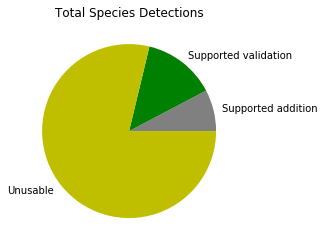

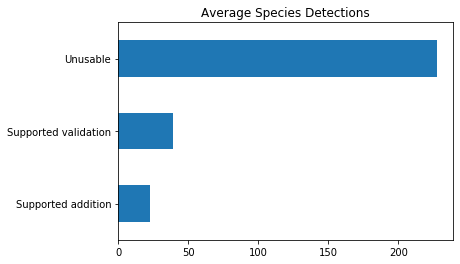

In [9]:
#Plot pie chart of total detections
plt1 = pivdf.drop(['Total detections']).plot(y=('Species-Habitat Detections',        'Total'), 
                                             kind='pie',
                                             legend=False, 
                                             title = "Total Species Detections",
                                             colors=['gray', 'g', 'y'])
plt1.set_ylabel("")
plt2 = pivdf.drop(['Total detections']).plot(y=('Species-Habitat Detections',        'Average'), 
                                             kind='barh', legend=False, 
                    title = "Average Species Detections")   

In [10]:
#Create pivot table summarizing the proportion of GAP systems validated 
piveval = masteval.pivot_table(index = masteval.index,
                           aggfunc = {'GAP_types' : [np.mean, sum, lambda x: len(x.unique())]},
                           fill_value = 0).sort_index()
piveval.rename(columns={"GAP_types" : "GAP Systems Validated by WVBBA", "mean" : "Average", "sum" : "Total", "<lambda_0>" : "Count"}, inplace=True)
print(piveval)

            GAP Systems Validated by WVBBA                 
                                     Count    Average Total
Additions                                7   1.688406   233
Unvalidated                             47  18.478261  2550
Validated                                8   1.768116   244


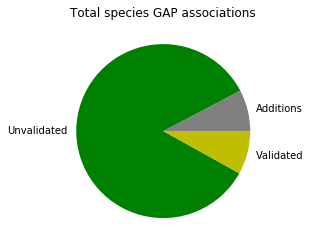

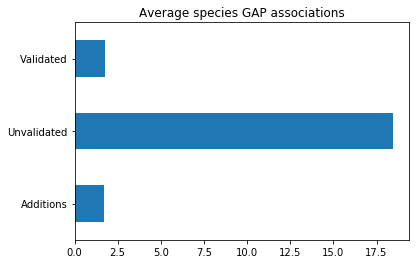

In [12]:
#Plot tables of the sum of validated GAP associations and the average per species
plt3 = piveval.plot(y=('GAP Systems Validated by WVBBA',        'Total'), 
                                             kind='pie',
                                             legend=False, 
                                             title = "Total species GAP associations",
                                             colors=['gray', 'g', 'y'])
plt3.set_ylabel("")
plt4 = piveval.plot(y=('GAP Systems Validated by WVBBA',        'Average'), kind='barh', legend=False, 
                    title = "Average species GAP associations") 